In [466]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle


from sklearn.decomposition import PCA

from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


import random
import tensorflow as tf

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [467]:
def get_initial_11(team):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'][:11].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

## Top 15
Nos sirve para tener mas jugadores para entrenar, no nos interesan todos porque hay algunos que juegan muy poco y pueden cambiar mucho los resultados pero el top 15 suele ser el que mas participa

In [468]:
def get_frequent_players(team, min_minutes=1400):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        
        df_filtered = df[df['MinutesPlayed'] > min_minutes]
        
        df_filtered = df_filtered.sort_values(by='MinutesPlayed', ascending=False)
        
        return df_filtered['PlayerName'].tolist()
    
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [469]:
def get_team_players(team):
    base_path = '//Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [470]:
def load_player_matrix(team_name, player_name, matrix_name):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    if matrix_name != 'pass_transition_matrix':
        matrix_path = os.path.join(base_path, team_name, player_name, f'{matrix_name}.csv')
        matrix = np.loadtxt(matrix_path, delimiter=',')
    else:
        matrix_path = os.path.join(base_path, team_name, player_name, f'{matrix_name}.npy')
        matrix = np.load(matrix_path)
    return matrix

In [471]:
def aggregate_team_matrices(team, players):
    team_matrixes = {
        'pass_matrix':  np.zeros((10, 10)),
        'shot_matrix': np.zeros((10, 10)),
        'defense_matrix': np.zeros((10, 10)),
        'goal_matrix': np.zeros((10, 10)),
        'errors_matrix': np.zeros((10, 10)),
        'out_matrix': np.zeros((10, 10))
    }

    for player in players:
        team_matrixes['pass_matrix'] += load_player_matrix(team, player, 'pass_matrix')
        team_matrixes['shot_matrix'] += load_player_matrix(team, player, 'shot_matrix')
        team_matrixes['defense_matrix'] += load_player_matrix(team, player, 'defense_matrix')
        team_matrixes['goal_matrix'] += load_player_matrix(team, player, 'goal_matrix')
        team_matrixes['errors_matrix'] += load_player_matrix(team, player, 'errors_matrix')
        team_matrixes['out_matrix'] += load_player_matrix(team, player, 'out_matrix') 
    
    return team_matrixes

In [472]:
teams_list = ['Arsenal', 'Everton', 'Fulham', 'Manchester City',
       'Newcastle United', 'Queens Park Rangers', 'Reading',
       'West Bromwich Albion', 'West Ham United', 'Wigan Athletic',
       'Aston Villa', 'Chelsea', 'Liverpool', 'Manchester United',
       'Norwich City', 'Southampton', 'Stoke City', 'Sunderland',
       'Swansea City', 'Tottenham Hotspur', 'Vancouver Whitecaps', 'Philadelphia Union', 'Chivas USA',
       'FC Dallas', 'Seattle Sounders FC', 'Houston Dynamo',
       'Portland Timbers', 'LA Galaxy', 'San Jose Earthquakes',
       'Colorado Rapids', 'Chicago Fire', 'D.C. United', 'Toronto FC',
       'New York Red Bulls', 'Sporting Kansas City', 'Montreal Impact',
       'Real Salt Lake', 'Columbus Crew', 'New England Revolution']

## Construccion del dataframe con informacion de jugadores

In [473]:
base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'

team_matrixes = {}
player_matrixes = {}
all_players = []

for team in teams_list:
    team_csv_path = os.path.join(base_path, f"{team}/{team}_summary.csv")
    team_data = pd.read_csv(team_csv_path)
    
    players = get_frequent_players(team) 
    for player in players:
        if player not in player_matrixes:
            player_matrixes[player] = {}
        
        types = {
           
            'pass_matrix':  np.zeros((10, 10)),
            'shot_matrix': np.zeros((10, 10)),
            'defense_matrix': np.zeros((10, 10)),
            'goal_matrix': np.zeros((10, 10)),
            'errors_matrix': np.zeros((10, 10)),
            'out_matrix': np.zeros((10, 10))
        }
        
        all_players.append(player)
        
        for type_name in types:
            
            player_matrixes[player][type_name] = load_player_matrix(team, player, type_name)
        
        player_info = team_data[team_data['PlayerName'] == player]
        if not player_info.empty:
            position = player_info['Position'].values[0]
            cards = player_info['Cards'].values[0]
            time_played = player_info['MinutesPlayed'].values[0]
            player_matrixes[player]['team'] = team
            player_matrixes[player]['position'] = position
            player_matrixes[player]['cards'] = cards
            player_matrixes[player]['time'] = time_played

    team_matrixes[team] = aggregate_team_matrices(team, players)

In [474]:
for team in teams_list:
    for matrix in team_matrixes[f'{team}']:
        team_matrixes[f'{team}'][matrix] = np.sum(team_matrixes[f'{team}'][matrix] * 90)

In [475]:
for player in all_players:
    for matrix_name, matrix_value in player_matrixes[f'{player}'].items():
        if matrix_name == 'cards':
            player_matrixes[f'{player}'][matrix_name] = matrix_value * 90
        elif matrix_name == 'time':
            player_matrixes[f'{player}'][matrix_name] = matrix_value / 90
        elif matrix_name == 'position' or matrix_name == 'team':
            pass
        else:
            player_matrixes[f'{player}'][matrix_name] = np.sum(matrix_value * 90)

In [476]:
player_dataframe = pd.DataFrame(player_matrixes).T

In [477]:
player_dataframe['position'] = player_dataframe['position'].replace('Forward', 'Striker')

In [478]:
player_dataframe

,pass_matrix,shot_matrix,defense_matrix,goal_matrix,errors_matrix,out_matrix,team,position,cards,time
"Cazorla, Santiago",56.60181,3.02211,10.14408,0.31536,3.75804,2.81196,Arsenal,Midfielder,0.026277,38.055556
"Mertesacker, Per",43.94241,0.47952,10.52028,0.08451,4.31514,1.35297,Arsenal,Defender,0.112817,35.455556
"Arteta, Mikel",73.21698,0.55062,13.47732,0.17388,4.23117,1.5939,Arsenal,Midfielder,0.173913,34.5
"Giroud, Olivier",16.45299,3.92085,7.73109,0.40302,7.73145,3.11355,Arsenal,Striker,0.14658,27.288889
"Walcott, Theo",17.0568,3.28293,4.60359,0.5283,2.30157,2.15019,Arsenal,Striker,0.113208,26.5
...,...,...,...,...,...,...,...,...,...,...
Chris Tierney,27.11772,0.69381,9.49005,0.03654,4.59945,4.08915,New England Revolution,Defender,0.072993,27.4
Scott Caldwell,32.30739,0.26469,11.15973,0.0378,3.9339,1.62603,New England Revolution,Midfielder,0.113493,26.433333
Bobby Shuttleworth,0.0,0.0,0.0,0.0,0.0,0.0,New England Revolution,Goalkeeper,0.0,23.988889
A.J. Soares,22.16727,0.25605,15.3585,0.05121,5.98995,4.04523,New England Revolution,Defender,0.204778,19.533333


## Agregado de metricas de participación

In [479]:
for team in teams_list:
    team_stats = team_matrixes[team]
    for player in get_frequent_players(team):
        if player in player_dataframe.index:
            for stat_name, stat_value in team_stats.items():
                player_dataframe.loc[player, f'{stat_name}_team'] = stat_value

In [480]:
metrics = ['pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 'errors_matrix', 'out_matrix']

for metric in metrics:
    player_dataframe[f'{metric}_contribution'] = player_dataframe[metric] / player_dataframe[f'{metric}_team']

In [481]:
player_dataframe = player_dataframe.round(2)

In [482]:
player_dataframe = player_dataframe.reset_index().rename(columns={'index': 'player'})

## Agregamos la variable a predecir: el ranking

In [483]:
ranking_PL = pd.read_excel('/Users/luisalawson/Desktop/Ranking.xlsx')
ranking_MLS = pd.read_excel('/Users/luisalawson/Desktop/RankingMLS.xlsx')

In [484]:
ranking_PL['League'] = 'PL'
ranking_MLS['League'] = 'MLS'

ranking = pd.concat([ranking_PL, ranking_MLS], ignore_index=True)

In [485]:
ranking 

,Equipo,Posicion,Puntos,League
0,Manchester United,1,89,PL
1,Manchester City,2,78,PL
2,Chelsea,3,75,PL
3,Arsenal,4,73,PL
4,Tottenham Hotspur,5,72,PL
5,Everton,6,63,PL
6,Liverpool,7,61,PL
7,West Bromwich Albion,8,49,PL
8,Swansea City,9,46,PL
9,West Ham United,10,46,PL


In [486]:
ranking.reset_index(drop=True, inplace=True)

In [487]:
player_dataframe = player_dataframe.merge(ranking[['Equipo', 'Posicion', 'League']], left_on='team', right_on='Equipo', how='left')
player_dataframe = player_dataframe.drop(columns=['Equipo'])
player_dataframe = player_dataframe.rename(columns={'Posicion': 'TeamRanking'})

## Modelo clasificador

In [488]:
player_dataframe['TeamRanking'] = player_dataframe['TeamRanking'].apply(lambda x: 0 if x <= 4 else (1 if x <= 8 else (2 if x <= 12 else (3 if x <= 16 else 4))))

In [489]:
player_dataframe = player_dataframe[player_dataframe['position'] != 'Goalkeeper']

In [490]:
# Si queremos que sean 3 clases (probar mas adelante, ya probe y no dio tanta diferencia, mejor 5)

# player_dataframe['TeamRanking'] = player_dataframe['TeamRanking'].apply(
#     lambda x: 0 if x <= 6 else (1 if x <= 13 else 2)
# )

In [491]:
# eliminamos el nombre (no me aporta en nada), el equipo (porque se correlaciona con el ranking y seria data leak) 
# y el team Ranking porque es lo que queremos predecir
X = player_dataframe.drop(columns=['player', 'team', 'TeamRanking'])
# nos quedamos con la variable a predecir
y = player_dataframe['TeamRanking']

In [492]:
X, y = shuffle(X, y, random_state=42)

In [493]:
# la posicion la pasamos a One Hot encoding porque son categoricas y no nos sirve tenerla asi
X = pd.get_dummies(X, columns=['position'], prefix='position')
X = pd.get_dummies(X, columns=['League'], prefix='League')
# drop de las variables de equipo porque tambien se correlaciona con el ranking (mismos jugadores del mismo equipo tienen esto igual) y 
# estariamos haciendo data leak
X = X.drop(columns = ['pass_matrix_team',
       'shot_matrix_team', 'defense_matrix_team', 'goal_matrix_team',
       'errors_matrix_team', 'out_matrix_team'])

In [494]:
# primero normalizamos los valores (le sirve a los modelos para predecir tener los nros en un rango mas chico creo)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# separamos en los datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# PROBAR MODELOS ACA - Poner los valores de accuracy asi vamos teniendo info 
# (lo puse en la celda que sigue para no tener muy largo aca), si cambiamos uno pegar el viejo en la de abajo, 
# poner los nros y dejar el que probamos aca

model = models.Sequential([
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.05), input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.05)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    layers.Dense(5, activation='softmax')
])

# aca podemos probar con optimizadores pero la loss mantenerla igual x ser categorica (no usar mse)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# probar con patience, esto es si no me mejora la val_loss en 20 iteraciones dejar (xq seguro esta haciendo 
# overfitting o ya no puede levantar mas patrones)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# entrenamos al modelo - probar con epoch y batch size para ver si cambia en algo
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]

)

Epoch 1/200


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.1803 - loss: 13.4360 - val_accuracy: 0.2222 - val_loss: 12.6023 - learning_rate: 5.0000e-04
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2543 - loss: 12.3650 - val_accuracy: 0.2639 - val_loss: 11.6525 - learning_rate: 5.0000e-04
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2354 - loss: 11.4478 - val_accuracy: 0.3056 - val_loss: 10.7690 - learning_rate: 5.0000e-04
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2584 - loss: 10.5649 - val_accuracy: 0.2639 - val_loss: 9.9507 - learning_rate: 5.0000e-04
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2944 - loss: 9.7398 - val_accuracy: 0.2639 - val_loss: 9.1945 - learning_rate: 5.0000e-04
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3352 - loss: 8.9988 - val_accuracy: 0.2917 - val_loss: 8.4978 - learning_rate: 5.0000e-04
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2922 - loss: 8.33

In [298]:
## MODELOS QUE YA PROBAMOS

# accuracy: 0.9124 - val_accuracy: 0.4792 - test_accuracy: 0.4799
# model = models.Sequential([
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.3),
#     layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     #si cambiamos la agrupacion del ranking cambiar en el out de esta
#     layers.Dense(5, activation='softmax')  
# ])

# model = models.Sequential([
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.3),
#     layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.Dropout(0.2),
#     layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.BatchNormalization(),
#     layers.Dense(5, activation='softmax')
# ])

# model = models.Sequential([
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.3),
#     layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.Dropout(0.2),
#     layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.BatchNormalization(),
#si cambiamos la agrupacion del ranking cambiar en el out de esta
#     layers.Dense(5, activation='softmax')
# ])


# val_acc -> 0.27 | acc -> 0.6
# model = models.Sequential([
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.02), input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.4),
#     layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.02)),
#     layers.Dropout(0.3),
#si cambiamos la agrupacion del ranking cambiar en el out de esta
#     layers.Dense(5, activation='softmax')  
# ])

# val_acc -> 0.22 | acc -> 0.4

# model = models.Sequential([
#     layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.3),
#     layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.Dropout(0.2),
#si cambiamos la agrupacion del ranking cambiar en el out de esta
#     layers.Dense(5, activation='softmax')  
# ])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4187 - loss: 1.5754
Test Accuracy: 0.40


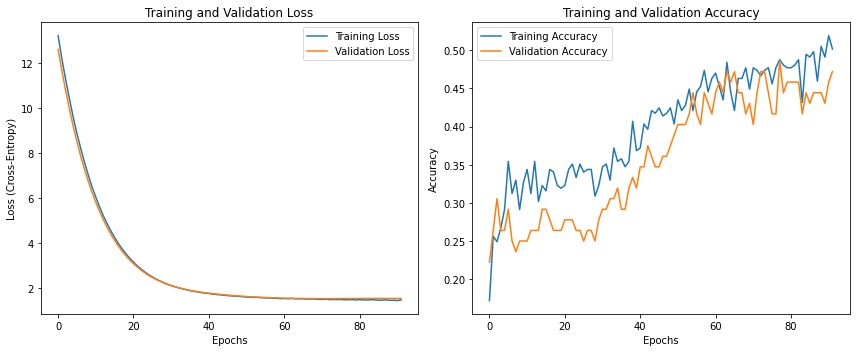

In [495]:
# Vemos como da en test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# graficos de accuracy y de loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross-Entropy)')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [496]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
y_pred_proba = model.predict(X_test)

roc_auc = roc_auc_score(y_test_bin, y_pred_proba, average="macro")
print(f"Neural Network ROC AUC: {roc_auc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Neural Network ROC AUC: 0.6968


In [497]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_loss}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4187 - loss: 1.5754
Test MAE: 1.6136293411254883


## Random forest & XGBoost

In [498]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_y_pred_proba = rf_model.predict_proba(X_test)
rf_y_pred = rf_model.predict(X_test)

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
rf_roc_auc = roc_auc_score(y_test_bin, rf_y_pred_proba, average="macro")
print(f"Random Forest ROC AUC: {rf_roc_auc:.4f}")

rf_accuracy = accuracy_score(y_test, rf_y_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")


Random Forest ROC AUC: 0.6269
Random Forest Accuracy: 0.3222


In [499]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(objective='multi:softmax', num_class=5, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_y_pred_proba = xgb_model.predict_proba(X_test)
xgb_y_pred = xgb_model.predict(X_test)

xgb_roc_auc = roc_auc_score(y_test_bin, xgb_y_pred_proba, average="macro")
print(f"XGBoost ROC AUC: {xgb_roc_auc:.4f}")

xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

XGBoost ROC AUC: 0.6664
XGBoost Accuracy: 0.3889


## Probando el ranking en base al modelo

In [500]:
team_rankings_pred = {}

for team in teams_list:
    players = get_initial_11(team)
    player_predictions = []

    for player in players:
        if player in player_matrixes:
            player_row = player_dataframe[player_dataframe['player'] == player].copy()
            
            # Check if player_row is empty
            if player_row.empty:
                print(f"Player {player} not found in player_dataframe.")
                continue  # Skip to the next player

            required_columns = [
                'pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 
                'errors_matrix', 'out_matrix', 'cards', 'time',
                'pass_matrix_contribution', 'shot_matrix_contribution', 
                'defense_matrix_contribution', 'goal_matrix_contribution', 
                'errors_matrix_contribution', 'out_matrix_contribution'
            ]
            position_columns = [
                'position_Defender', 'position_Midfielder', 
                'position_Striker'
            ]
            league_columns = [
                'League_MLS', 'League_PL'
            ]

            player_position = player_row['position'].values[0]
            player_league = player_row['League'].values[0]

            if player_position == 'Goalkeeper':
                continue 

            for pos_col in position_columns:
                player_row.loc[:, pos_col] = 1 if player_position in pos_col else 0
            
            for league_col in league_columns:
                player_row.loc[:, league_col] = 1 if player_league in pos_col else 0

            player_row = player_row[required_columns + position_columns + league_columns]

            if player_row.empty:
                print(f"No valid data for player {player} after processing.")
                continue

            player_features = pd.DataFrame(player_row[required_columns + position_columns + league_columns])
            player_features = scaler.transform(player_features)

            player_prediction = model.predict(player_features)
            predicted_class = np.argmax(player_prediction[0])

            player_predictions.append(predicted_class)
        else:
            print(f"Player {player} not found in player_matrixes")

    # Average predictions
    if player_predictions:
        team_rankings_pred[team] = np.mean(player_predictions)
    else:
        print(f"No predictions for team {team}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Player Szczesny, Wojciech not found in player_dataframe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Player Howard, Tim not found in player_dataframe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Player Schwarzer, Mark not found in player_dataframe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/

In [501]:
team_rankings_pred_df = pd.DataFrame(team_rankings_pred.items(), columns=['Team', 'PredictedRanking'])

In [502]:
team_rankings_pred_df.sort_values(by='PredictedRanking', ascending=True)
team_rankings_pred_df = team_rankings_pred_df.merge(ranking[['Equipo', 'Posicion']], left_on='Team', right_on='Equipo', how='left')
team_rankings_pred_df['Real'] = team_rankings_pred_df['Posicion'].apply(lambda x: 0 if x <= 4 else (1 if x <= 8 else (2 if x <= 12 else (3 if x <= 16 else 4))))
# si hacemos con 3 descomentar la de abajo y comentar la de arriba
# team_rankings_pred_df['Real'] = team_rankings_pred_df['Posicion'].apply(
#     lambda x: 0 if x <= 6 else (1 if x <= 13 else 2)
# )

team_rankings_pred_df = team_rankings_pred_df.rename(columns={'PredictedRanking': 'Predicted'})


team_rankings_pred_df['diff'] = team_rankings_pred_df['Real'] - team_rankings_pred_df['Predicted']
team_rankings_pred_df = team_rankings_pred_df[['Team', 'Predicted', 'Real', 'diff']]

In [503]:
teams_PL = ranking_PL['Equipo'].unique()
teams_MLS = ranking_MLS['Equipo'].unique()

In [504]:
team_rankings_pred_df = team_rankings_pred_df.sort_values(by='Predicted', ascending=True)
ranking_PL_pred = team_rankings_pred_df[team_rankings_pred_df['Team'].isin(teams_PL)]
ranking_MLS_pred = team_rankings_pred_df[team_rankings_pred_df['Team'].isin(teams_MLS)]

In [505]:
ranking_PL_pred

,Team,Predicted,Real,diff
0,Arsenal,0.000000,0,0.000000
3,Manchester City,0.000000,0,0.000000
13,Manchester United,0.000000,0,0.000000
11,Chelsea,0.000000,0,0.000000
18,Swansea City,0.000000,2,2.000000
12,Liverpool,0.200000,1,0.800000
15,Southampton,0.363636,3,2.636364
19,Tottenham Hotspur,0.400000,1,0.600000
1,Everton,0.800000,1,0.200000
2,Fulham,0.900000,2,1.100000


In [506]:
ranking_MLS_pred

,Team,Predicted,Real,diff
26,Portland Timbers,0.900000,0,-0.900000
25,Houston Dynamo,1.000000,2,1.000000
36,Real Salt Lake,1.000000,1,0.000000
34,Sporting Kansas City,1.400000,0,-1.400000
33,New York Red Bulls,1.600000,0,-1.600000
35,Montreal Impact,2.000000,2,0.000000
27,LA Galaxy,2.000000,1,-1.000000
20,Vancouver Whitecaps,2.454545,3,0.545455
24,Seattle Sounders FC,2.600000,1,-1.600000
23,FC Dallas,2.900000,3,0.100000


## Player swap
#### van Persie, Robin -> Mackie, Jamie

In [32]:
team_rankings_pred = {}

for team in teams_list:
    players = get_initial_11(team)
    if team == 'Manchester United' and 'van Persie, Robin' in players:
        players = [player if player != 'van Persie, Robin' else 'Mackie, Jamie' for player in players]
    
    if team == 'Queens Park Rangers' and 'Mackie, Jamie' in players:
        players = [player if player != 'Mackie, Jamie' else 'van Persie, Robin' for player in players]
        
    player_predictions = []

    for player in players:
        if player in player_matrixes:
            player_row = player_dataframe[player_dataframe['player'] == player].copy()
            required_columns = [
                'pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 
                'errors_matrix', 'out_matrix', 'cards', 'time',
                'pass_matrix_contribution', 'shot_matrix_contribution', 
                'defense_matrix_contribution', 'goal_matrix_contribution', 
                'errors_matrix_contribution', 'out_matrix_contribution'
            ]
            position_columns = [
                'position_Defender', 'position_Goalkeeper', 'position_Midfielder', 
                'position_Striker'
            ]

            player_position = player_row['position'].values[0]
            for pos_col in position_columns:
                player_row.loc[:, pos_col] = 1 if player_position in pos_col else 0

            player_row = player_row[required_columns + position_columns]

            player_features = pd.DataFrame(player_row[required_columns + position_columns])
            player_features = scaler.transform(player_features)

            player_prediction = model.predict(player_features)
            predicted_class = np.argmax(player_prediction[0])

            player_predictions.append(predicted_class)
        else:
            print(f"Player {player} not found in player_matrixes")

    if player_predictions:
        team_rankings_pred[team] = np.mean(player_predictions)
    else:
        print(f"No predictions for team {team}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

## Podemos ver de entrenar modelos por posicion

In [40]:
# hay muy pocos datos x ahora especialmente gk
player_dataframe['position'].value_counts()

position
Midfielder    201
Defender      182
Striker       113
Name: count, dtype: int64

## MLS data interpretation

esto ignorarlo es para preparar datos para tener mas para entrenar

In [37]:
MLS_df = pd.read_excel('/Users/luisalawson/Downloads/MLS-Opta.xlsx')

In [38]:
PL_df = pd.read_csv('/Users/luisalawson/Downloads/Sample Data/epl.csv', delimiter = ';')

In [39]:
MLS_df.drop(labels=['competition_name', 'competition_id'], axis=1, inplace=True)

In [40]:
MLS_df.rename(columns={'id': 'match_id', 'id.1': 'id'}, inplace=True)

In [47]:
PL_df

,season_id,match_id,home_team_id,home_team_name,away_team_id,away_team_name,id,event_id,date,time,...,sec,team_id,player_id,playerName,playerPosition,x,y,type,description,outcome
0,2012,441999,3,Arsenal,56,Sunderland,688830980,1,18Aug2012,2:31:54 PM,...,0,3,NaN,NaN,NaN,0,0,34,Team set up,1
1,2012,441999,3,Arsenal,56,Sunderland,1399442519,1,18Aug2012,2:33:35 PM,...,0,56,NaN,NaN,NaN,0,0,34,Team set up,1
2,2012,441999,3,Arsenal,56,Sunderland,1641098842,2,18Aug2012,3:01:59 PM,...,0,3,NaN,NaN,NaN,0,0,32,Start,1
3,2012,441999,3,Arsenal,56,Sunderland,1755825990,2,18Aug2012,3:01:59 PM,...,0,56,NaN,NaN,NaN,0,0,32,Start,1
4,2012,441999,3,Arsenal,56,Sunderland,164697335,3,18Aug2012,3:02:00 PM,...,1,3,17733.0,"Podolski, Lukas",Striker,50,50,1,Pass,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648878,2012,442378,111,Wigan Athletic,7,Aston Villa,428661649,905,19May2013,5:51:58 PM,...,35,111,NaN,NaN,NaN,0,0,30,End,1
648879,2012,442378,111,Wigan Athletic,7,Aston Villa,1411196656,907,19May2013,6:00:29 PM,...,0,111,NaN,NaN,NaN,0,0,30,End,1
648880,2012,442378,111,Wigan Athletic,7,Aston Villa,948803408,908,19May2013,6:00:29 PM,...,0,111,NaN,NaN,NaN,0,0,37,Collection End,1
648881,2012,442378,111,Wigan Athletic,7,Aston Villa,803034702,810,19May2013,6:00:30 PM,...,0,7,NaN,NaN,NaN,0,0,30,End,1


In [42]:
MLS_df.loc[MLS_df['playerName'] == 'NotSpecified', ['playerName', 'playerPosition']] = ''

In [44]:
MLS_df.loc[MLS_df['playerName'].isin(['NotSpecified', 'NotFound']), ['playerName', 'playerPosition']] = ''

In [49]:
MLS_df['time'] = pd.to_datetime(MLS_df['time'], format='%H:%M:%S').dt.strftime('%I:%M:%S %p')
MLS_df['date'] = pd.to_datetime(MLS_df['date'], format='%Y-%m-%d').dt.strftime('%-d%b%Y')

In [51]:
MLS_df.to_csv('/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data/MLS_df.csv', index=False)